In [1]:
## processing
import numpy as np
import pandas as pd

## custom package
import tregseq

## visualization
import matplotlib.pyplot as plt
from IPython.display import Image

In this notebook, we take in sequencing data in the form of RNA and DNA counts for each promoter variant and compute information footprint by calculating mutual information. We will first test the code on experimental datasets and then we will generate information footprint based on the synthetic datasets we made in `simple_repression_synthetic_dataset.ipynb`.

The mutual information between two random variables $X$ and $Y$ is defined as
$$
I(X;Y) = \sum_{y \in Y} \sum_{x \in X} P_{X,Y}(x,y) \log_2{(\frac{P_{X,Y}(x,y)}{P_X(x)P_Y(y)})},
$$
where $P_X$ is the marginal probability distribution of $X$, $P_Y$ is the marginal probability distribution of $Y$, and $P_{X,Y}$ is the joint probability distribution between $X$ and $Y$.

Here, the two random variables that we care about are base identity at each position and expression levels. Therefore we can rewrite the expression for the information footprint at each position $i$ as
$$
I(X;Y) = \sum_{b} \sum_{\mu} P_{i}(b, \mu) \log_2{(\frac{P_{i}(b, \mu)}{P_i(b)P(\mu)})},
$$
where $b$ represents base identity and $\mu$ represents expression levels.

We explore different ways of representing base identity and expression levels in probabilistic terms and ask which definition of mutual information produces the "best" information footprint.

There are two ways of representing base identity, $b$. If we are interested in which nucleotide is at each position in each promoter variant, then $b$ can be one of the four nucleotides, A, T, C, G. Alternatively, we might only be concerned with whether a mutation has occured i.e. whether the base identity at position $i$ in the promoter variant is different from the base identity in the wild type sequence. With this type of **coarse graining**, $b$ can take the values of
$$
b = 
\begin{cases}
    0, & \text{if the base is mutated} \\
    1, & \text{if the base is wild type}.
\end{cases}
$$. 

To represent expression levels as a probability distribution, we group sequences in each range of expression levels into discrete bins. The key question here is then what is the ideal method of binning the sequences. We begin by normalizing expression levels (RNA/DNA count) and choosing $n$ equal sized bins for the normalized counts.

## Loading sequencing data

The data is taken from `/RegSeq/data/sequencing_data/ykgE_dataset_combined.csv`, which contains DNA count (`ct_0`), RNA count (`ct_1`), and the total count (`ct`) for each promoter variant.

In [2]:
fpath = '../data/ykgE_dataset_combined.csv'
df_ykgE = pd.read_csv(fpath)
df_ykgE.head()

,ct,ct_0,ct_1,seq
0,1.0,1.0,0.0,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...
1,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
2,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
3,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...
4,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...


The sequences in this dataset have an extra 20bp in the 3' end, so we trim it off before performing any analysis.

In [3]:
def trim_seqs(row):
    return row['seq'][:160]

In [4]:
df_ykgE['seq'] = df_ykgE.apply(trim_seqs, axis=1)

The main values that we care about here is the RNA count, but to account for the effect of multiple DNA templates on the expression levels, we "normalize" the RNA counts by dividing it by the DNA counts.

First we remove the rows with 0 DNA counts as they wouldn't be meaningful (since you cannot get mRNA without DNA) and would create division by 0 error.

In [5]:
df_ykgE = df_ykgE[df_ykgE.ct_0 != 0.0]

In [6]:
n_seqs = len(df_ykgE)
n_seqs

2072

Now we perform the normalization.

In [7]:
df_ykgE['norm_ct_1'] = df_ykgE['ct_1'] / df_ykgE['ct_0']

In [8]:
df_ykgE.head()

,ct,ct_0,ct_1,seq,norm_ct_1
0,1.0,1.0,0.0,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...,0.0
1,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,0.0
2,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,0.0
3,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,0.0
4,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,0.0


## Information footprint: Minimum binning

### 1. Representing mutations as probability distribution

Let's write down $P_i(b)$ by calculating the fraction of bases at each position that are wild type and the fraction that are mutated.

In [9]:
wtseq = 'TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG'

In [10]:
mut_list = df_ykgE['seq'].values

all_mutarr = tregseq.footprint.match_seqs(mut_list, wtseq)
all_mutarr

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [11]:
list_p_b = tregseq.footprint.get_p_b(all_mutarr, n_seqs)
list_p_b.shape

(160, 2)

### 2. Representing expression levels as probability distributions

To create the simplest probabilty distribution for expression levels, let's group RNA count into two bins - one with high expression levels and one with low expression levels.

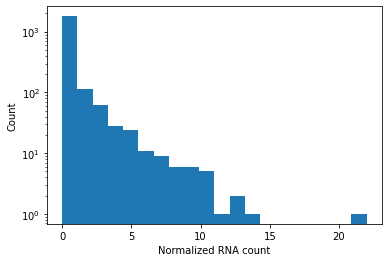

In [12]:
plt.hist(df_ykgE['norm_ct_1'], bins=20)
plt.xlabel('Normalized RNA count')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

The above plot shows the distribution of the normalized RNA count, let's first arbitrarily say we have a highly expressed gene if the normalized RNA count is more than or equal to 2 and we have a lowly expressed gene otherwise. Then we can calculate $p_{\mu}$ as follows:

In [13]:
mu_data = df_ykgE['norm_ct_1']

nbins = 2
upper_bound = 2
mu_bins, bin_cnt = tregseq.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
p_mu = tregseq.footprint.get_p_mu(bin_cnt, n_seqs)
p_mu

array([0.88272201, 0.11727799])

### 3. Calculating the joint probability distribution

To calculate the joint probability distribution, we need to count the number of sequences that are wild type and highly expressed, mutated and highly expressed, wild type and lowly expressed, and mutated and lowly expressed.

In [14]:
list_joint_p = tregseq.footprint.get_joint_p(all_mutarr, mu_bins, nbins, n_seqs)

### 4. Calculate mutual information at each position

Finally, we can calculate the information footprint by computing the mutual information at each position given the probability distributions that we have calculated above.

In [15]:
footprint = tregseq.footprint.MI(list_p_b, p_mu, list_joint_p)

### 5. Making information footprint

The information footprint is plotted below. We have smoothed the footprint using a sliding window with window size of 5. We have also coloured the footprints based on the expression shift, which we plot in `expression_shift.ipynb`.

There is a lot of noise but we do have high peaks at the RNAP binding sites (from -70 to -35) and at the repressor binding site (-35 to -20).

In [16]:
Image(url="../figs/ykgE_footprint_elife.jpg", width=620, height=150)

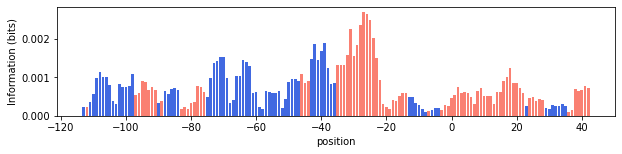

In [17]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)
plt.show()

## Information footprint: Increasing number of bins for expression levels

In [18]:
mut_list = df_ykgE['seq'].values
mu_data = df_ykgE['norm_ct_1']

In [19]:
nbins = 3
upper_bound = 3
footprint = tregseq.footprint.get_info_footprint(mut_list, mu_data, wtseq, nbins, upper_bound)

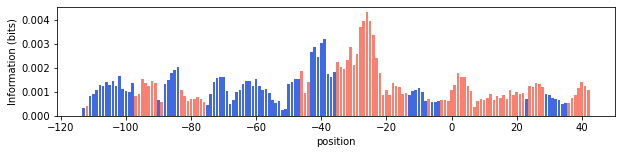

In [20]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)
plt.show()

In [21]:
nbins = 6
upper_bound = 10
footprint = tregseq.footprint.get_info_footprint(mut_list, mu_data, wtseq, nbins, upper_bound)

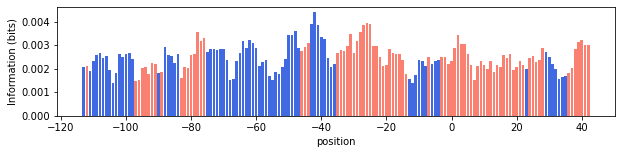

In [22]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)
plt.show()

## Testing on simulated LacI data

Now we test the algorithm on the data that we simulated for the lacZYA promoter in `simple_repression_synthetic_dataset.ipynb`. Here the RNAP binding site is from -41 to 0 and the repressor (lacI) binding site is from 0 to 21.


In [33]:
fpath = '../data/synthetic_datasets/lacI_synthetic_dataset.csv'
df_lacI = pd.read_csv(fpath)
df_lacI.head()

,seq,pbound,ct_0,ct_1,ct
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000271,22.0,5.0,27.0
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000049,9.0,0.0,9.0
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000689,1.0,0.0,1.0
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000939,13.0,12.0,25.0
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000272,13.0,3.0,16.0


In [34]:
wtseq = 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [35]:
df_lacI = df_lacI[df_lacI.ct_0 != 0.0]
df_lacI['norm_ct_1'] = df_lacI['ct_1'] / df_lacI['ct_0']

n_seqs = len(df_lacI)
mut_list = df_lacI['seq'].values
mu_data = df_lacI['norm_ct_1']

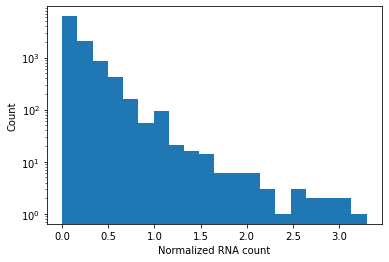

In [36]:
plt.hist(df_lacI['norm_ct_1'], bins=20)
plt.xlabel('Normalized RNA count')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [37]:
nbins = 3
upper_bound = 2
footprint = tregseq.footprint.get_info_footprint(mut_list, mu_data, wtseq, nbins, upper_bound)

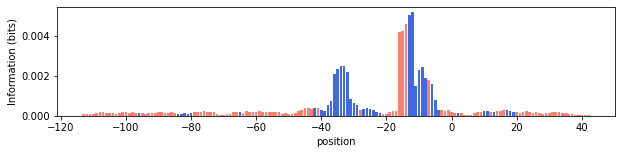

In [38]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)
plt.show()